# EQCM-D Analysis
These routines perform data analysis on the EQCM-D data.  It has been processed and fitted using Biolin Scien
tific's Q-sense software ('QSoft'), and is uploaded here as a csv file in code block 3.

## Import necessary modules.

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.fftpack import rfft, irfft, fftfreq
from scipy import signal

## Define some plotting parameters.
Create the list of colors, define the default font.

In [2]:
cmap = plt.get_cmap('plasma')
ndata = 10
color_ind = np.linspace(0,1,ndata)
colors = list()
for i in np.arange(ndata):
    colors.append(cmap(color_ind[i]))

    
fontname = 'Times New Roman'

## Upload the EQCM-D data

This is loaded as a pandas dataframe object:

In [3]:
QCMData = pd.read_csv('QCM_CV_0705_Data.csv')

## Split the data into one dataframe for each cycle.

In [4]:
Cycle1 = QCMData[QCMData['Cycle'] == 1]
Cycle2 = QCMData[QCMData['Cycle'] == 2]
Cycle3 = QCMData[QCMData['Cycle'] == 3]
Cycle4 = QCMData[QCMData['Cycle'] == 4]
Cycle5 = QCMData[QCMData['Cycle'] == 5]
Cycle6 = QCMData[QCMData['Cycle'] == 6]
Cycle7 = QCMData[QCMData['Cycle'] == 7]
Cycle8 = QCMData[QCMData['Cycle'] == 8]
Cycle9 = QCMData[QCMData['Cycle'] == 9]

# Let's print out the final SEI mass, after all cycling:
print('Final SEI Mass = ',Cycle9['Mass'].values[-1],' ng/cm2')

Final SEI Mass =  1207.189177  ng/cm2


# Let's take an initial look at the electrochemical (CV) data

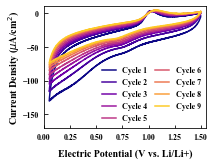

In [5]:
CVfig = plt.figure()
ax = CVfig.add_axes([0.2,0.21,0.75,0.75])
CVfig.set_size_inches([3.0,2.25])

# Plot the data for each cycle.
#    Multiply current densities by 1e6 to get micro-Amps per cm2:
plt.plot(Cycle1['V_Gam'],1e6*Cycle1['j'],color=colors[0])
plt.plot(Cycle2['V_Gam'],1e6*Cycle2['j'],color=colors[1])
plt.plot(Cycle3['V_Gam'],1e6*Cycle3['j'],color=colors[2])
plt.plot(Cycle4['V_Gam'],1e6*Cycle4['j'],color=colors[3])
plt.plot(Cycle5['V_Gam'],1e6*Cycle5['j'],color=colors[4])
plt.plot(Cycle6['V_Gam'],1e6*Cycle6['j'],color=colors[5])
plt.plot(Cycle7['V_Gam'],1e6*Cycle7['j'],color=colors[6])
plt.plot(Cycle8['V_Gam'],1e6*Cycle8['j'],color=colors[7])
plt.plot(Cycle9['V_Gam'],1e6*Cycle9['j'],color=colors[8])

# Set axis limits:
plt.ylim(-170,10)
plt.xlim(0.0,1.55)

# Specify tick marks on the x-axis (the defaults drawn by the program for the y-axis
#     are sufficient and do not need to be ovewritten).
plt.xticks([0.00,0.25,0.50,0.75,1.00,1.25,1.50])

# Set the font object and create the legend:
font = plt.matplotlib.font_manager.FontProperties(family=fontname,size=8,weight='normal')
plt.legend(['Cycle 1','Cycle 2','Cycle 3','Cycle 4','Cycle 5','Cycle 6','Cycle 7','Cycle 8','Cycle 9','Cycle 10'],
           frameon=False, columnspacing = 1.0, borderaxespad = 0.25, prop=font, ncol=2, handlelength=1.75)

# Set tick parameters:
ax = plt.gca()
ax.get_yaxis().set_tick_params('both', direction='in',pad=5.0)
ax.get_xaxis().set_tick_params('both', direction='in',pad=5.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
    
# Label the x and y axes:    
plt.xlabel('Electric Potential (V vs. Li/Li+)',fontname=fontname,fontsize=10,labelpad=7.5,fontweight='normal')
plt.ylabel('Current Density ($\mu$A/cm$^2$)',fontname=fontname,fontsize=10,labelpad=0.5)

# Save the plot.  It will go in the supplementary information
plt.savefig('QCM_CVraw_0705.pdf',dpi=500,format='pdf')

# Display the plot, here:
plt.show()



# Process the CV data

Hmm, there is a good bit of IR drop in that data - most of the currents are negative.  
This is perhaps not surprising, given the distance between the working and counter electrodes in our electrolyte bath. But it doesn't happen in every data set (this is still our best *combined* set of CV + QCM-D data).

Regardless, let's try and fix it.
## Correct the iR drop in the data:

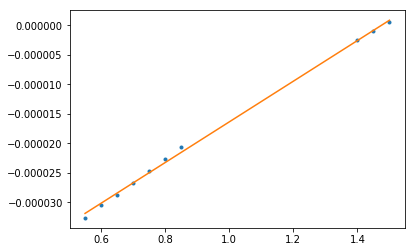

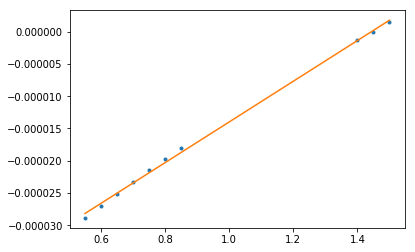

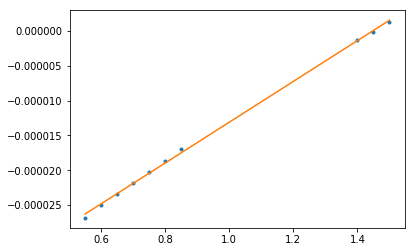

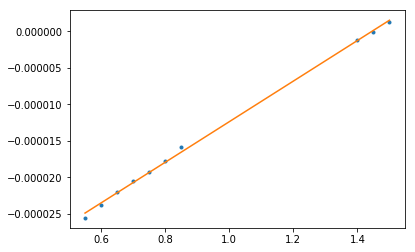

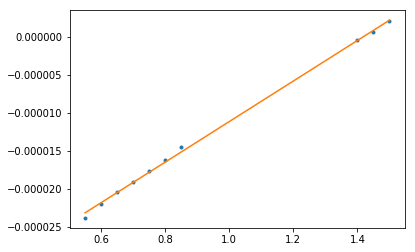

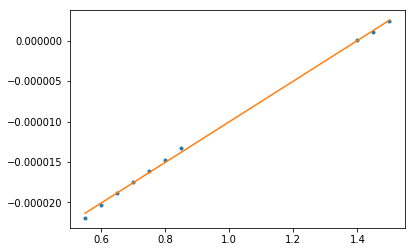

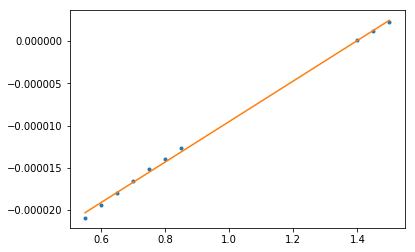

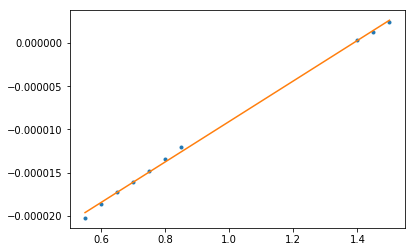

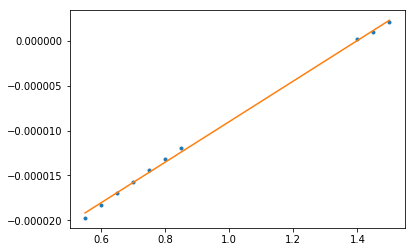

In [14]:
#Create a new dataframe column for 'jshift', the iR-corrected current density.
QCMData['jShift'] = 0

# Index of the 'halfway point' for each cycle, where we shift from a reducing sweep to an oxidizing sweep:
ihalfs = np.empty([1,9])
i_high_low = np.empty([1,9])
i_low_high = np.empty([1,9])

# Loop through all the cycles, and locate the indices for particular voltages:
for cycle in np.arange(9):
    Data = QCMData[QCMData['Cycle'] == cycle+1]
    i = 0
    i_half = 0
    
    #Locate the index for the terminal voltage between reducing and oxidizing sweeps:
    for index, row in Data.iterrows():
        if i:
            if Data.loc[index,'V_Gam'] >= Data.loc[index-1,'V_Gam']:
                i_half = index-1
                break
        i+=1

    # Save it to our array:
    ihalfs[0,cycle] = i_half
    
    # Split the cycle into a reducing and an oxidizing sweep:
    red = Data.loc[:i_half]
    ox = Data.loc[i_half:]
            
    # For the oxidizing sweep, locate the first row where V >= 0.32 V
    #    We will (somewhat arbitrarily) pick this to be the voltage where current = 0
    #       during the oxidizing sweep (this is based on other CV experiments conducted which 
    #       had lower iR drop).
    for index, row in ox.iterrows():
        if Data.loc[index,'V_Gam'] >= 0.32:
            ishift = index
            break
    
    # If this is the 8th reducing sweep, locate the first row where V <= 1.3 V.  
    #   We will use this index to approximate our charging current.
    if cycle==8:
        for index, row in red.iterrows():
            if Data.loc[index,'V_Gam'] <= 1.3:
                ishift2 = index
                break
                
    # Find the point in each sweep where the potential crosses 1.0 V:
    for index, row in ox.iterrows():
        if Data.loc[index,'V_Gam'] >= 1.0:
            i_low_high[0,cycle] = index
            break    
    for index, row in red.iterrows():
        if Data.loc[index,'V_Gam'] <= 1.0:
            i_high_low[0,cycle] = index
            break    

    # We're going to fit the data to a linear equation, but only for particular voltages (where the curve is linear).
    #     ID the voltages where the trace is roughly linear during oxidation (i.e. excluding the oxidation peak)
    iVolt = np.array((0.55,0.6,0.65,0.7,0.75,0.8,0.85,1.4,1.45,1.5))
                      
    # The relevant voltages are a little different for the final cycle:
    if cycle==9:
        iVolt = np.arange(0.55,0.95,0.05)

    # Interpolate to find the currents corresponding to each voltage in iVolt, for the oxidizing sweep:
    i_ox = np.interp(iVolt,ox['V_Gam'],ox['j'])

    # Plot i vs. V:
    plt.plot(iVolt,i_ox,'.')

    # Fit the data to a 1st order (linear) polynomial:
    iR = np.polyfit(iVolt,i_ox,1)
    # The poly1d object is a way of easily handling and manipulating the polynomial coefficients:
    fit = np.poly1d(iR)

    # Plot the linear fit on top of the data, to make sure we ID'ed an appropriate linear region:
    plt.plot(iVolt,fit(iVolt))
    # See below - we have good linear fits for each cycle.
    plt.show()
    
    
    # iR[0] is the slope, iR[1] is the intercept.  Shift the data to remove the slope found in the linear region:
    QCMData.loc[QCMData.Cycle==cycle+1,'jShift'] = (Data['j'].values - (iR[1]/iR[0] + Data['V_Gam'].values)*iR[0])
       
# Shift all currents such that they cross zero current at roughly V = 0.32 V.
QCMData.loc[:,'jShift'] = QCMData.loc[:,'jShift'].values - QCMData.loc[ishift,'jShift']

# For the MPE calculations, we want only the charge transfer current.  Use the current at 1.3 V
#    during the final sweep as an approximation of the double layer charging current, and subtract
#    off this amount.  Save this as 'j_MPE':
QCMData['j_MPE'] = QCMData.loc[:,'jShift'].values - QCMData.loc[ishift2,'jShift']


## Re-load the `QCMData` dataframes, now with the shifted current densities, to the individual cycles

In [15]:
Cycle1 = QCMData[QCMData['Cycle'] == 1]
Cycle2 = QCMData[QCMData['Cycle'] == 2]
Cycle3 = QCMData[QCMData['Cycle'] == 3]
Cycle4 = QCMData[QCMData['Cycle'] == 4]
Cycle5 = QCMData[QCMData['Cycle'] == 5]
Cycle6 = QCMData[QCMData['Cycle'] == 6]
Cycle7 = QCMData[QCMData['Cycle'] == 7]
Cycle8 = QCMData[QCMData['Cycle'] == 8]
Cycle9 = QCMData[QCMData['Cycle'] == 9]

## Plot the new, shfited CV data.  This is Figure 4a, in the paper:

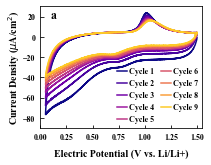

In [16]:
# Figure 4a - cyclic voltammetry  
CVfig = plt.figure()
ax = CVfig.add_axes([0.2,0.21,0.75,0.75])
CVfig.set_size_inches([3.0,2.25])

# Plot the data for each cycle.
#    Multiply current densities by 1e6 to get micro-Amps per cm2:
plt.plot(Cycle1['V_Gam'],1e6*Cycle1['jShift'],color=colors[0])
plt.plot(Cycle2['V_Gam'],1e6*Cycle2['jShift'],color=colors[1])
plt.plot(Cycle3['V_Gam'],1e6*Cycle3['jShift'],color=colors[2])
plt.plot(Cycle4['V_Gam'],1e6*Cycle4['jShift'],color=colors[3])
plt.plot(Cycle5['V_Gam'],1e6*Cycle5['jShift'],color=colors[4])
plt.plot(Cycle6['V_Gam'],1e6*Cycle6['jShift'],color=colors[5])
plt.plot(Cycle7['V_Gam'],1e6*Cycle7['jShift'],color=colors[6])
plt.plot(Cycle8['V_Gam'],1e6*Cycle8['jShift'],color=colors[7])
plt.plot(Cycle9['V_Gam'],1e6*Cycle9['jShift'],color=colors[8])

# Set axis limits:
plt.ylim(-90,30)
plt.xlim(0.0,1.55)

# Specify tick marks on the x-axis (the defaults drawn by the program for the y-axis
#     are sufficient and do not need to be ovewritten).
plt.xticks([0.00,0.25,0.50,0.75,1.00,1.25,1.50])

# Set the font object and create the legend:
font = plt.matplotlib.font_manager.FontProperties(family=fontname,size=8,weight='normal')
plt.legend(['Cycle 1','Cycle 2','Cycle 3','Cycle 4','Cycle 5','Cycle 6','Cycle 7','Cycle 8','Cycle 9','Cycle 10'],
           frameon=False, columnspacing = 0.75, borderaxespad = 0.15, prop=font, ncol=2, handlelength=1.25, handletextpad=0.25)

# Set tick parameters:
ax = plt.gca()
ax.get_yaxis().set_tick_params('both', direction='in',pad=5.0)
ax.get_xaxis().set_tick_params('both', direction='in',pad=5.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
    
# Label the x and y axes:     
plt.xlabel('Electric Potential (V vs. Li/Li+)',fontname=fontname,fontsize=10,labelpad=7.5,fontweight='normal')
plt.ylabel('Current Density ($\mu$A/cm$^2$)',fontname=fontname,fontsize=10,labelpad=0.5)

plt.annotate('a',xy=[0.1,15],color='k',va='bottom',family=fontname,size=12,annotation_clip=False)

# Save the plot.  
plt.savefig('../QCM_CVshift_0705.pdf',dpi=500,format='pdf')

# Inspect the plot, here:
plt.show()

## Figure 4b: Plot the mass uptake data

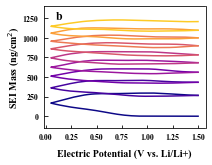

In [17]:
QCMfig = plt.figure()
ax = QCMfig.add_axes([0.2,0.21,0.75,0.75])
QCMfig.set_size_inches([3.0,2.25])

# Plot the data for each cycle:
plt.plot(Cycle1['V_Gam'],Cycle1['Mass'],color=colors[0])
plt.plot(Cycle2['V_Gam'],Cycle2['Mass'],color=colors[1])
plt.plot(Cycle3['V_Gam'],Cycle3['Mass'],color=colors[2])
plt.plot(Cycle4['V_Gam'],Cycle4['Mass'],color=colors[3])
plt.plot(Cycle5['V_Gam'],Cycle5['Mass'],color=colors[4])
plt.plot(Cycle6['V_Gam'],Cycle6['Mass'],color=colors[5])
plt.plot(Cycle7['V_Gam'],Cycle7['Mass'],color=colors[6])
plt.plot(Cycle8['V_Gam'],Cycle8['Mass'],color=colors[7])
plt.plot(Cycle9['V_Gam'],Cycle9['Mass'],color=colors[8])

# Set the tick parameters:
ax = plt.gca()
ax.get_yaxis().set_tick_params('both', direction='in',pad=5.0)
ax.get_xaxis().set_tick_params('both', direction='in',pad=5.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)

# Set y limits:
plt.ylim(-150,1400)

# Set the tick labels on the x-axis to match those for figures a and c:
plt.xticks([0.00,0.25,0.50,0.75,1.00,1.25,1.50])
# Set the y-axis tick labels:
plt.yticks([0, 250, 500, 750, 1000, 1250])

# Label the axes:
plt.xlabel('Electric Potential (V vs. Li/Li+)',fontname=fontname,fontsize=10,labelpad=7.5,fontweight='normal')
plt.ylabel('SEI Mass (ng/cm$^2$)',fontname=fontname,fontsize=10,labelpad=0.5)

plt.annotate('b',xy=[0.1,1200],color='k',va='bottom',family=fontname,size=12,annotation_clip=False)

# Save the plot:
plt.savefig('../QCM_mass_0705.pdf',dpi=500,format='pdf')

# Inspect the plot, here:
plt.show()

# Now to analyze the QCM-D data.

We want to calculate the data for Table 2, as well as calculate the MPE.
## First, convert the current into the amount of charge (Coulombs) added per time step:

In [18]:
# Charge added in the given time step:
QCMData['dQ'] = (QCMData['j_MPE'].values*(QCMData['t_Gam'].values - np.hstack([0,QCMData['t_Gam'].values[:-1]])))

# Create dataframe entries for the charge added and mpe for that time step:
QCMData['Q'] = 0
QCMData['mpe'] = 0

# Load the first data point manually:
QCMData.loc[0,'Q'] = QCMData['dQ'][0]

# For all other time steps j, calculate the total charge delivered as Q[j-1] + dQ[j]
for index, row in QCMData.iterrows():
    if index != 0:
        QCMData.loc[index,'Q'] = QCMData.loc[index-1,'Q'] + QCMData.loc[index,'dQ']

## Analyze the data:

In [35]:
cycles = np.arange(9)
max = 1.1   #max voltage for calculations
step = 0.05   #step size for voltage windows to average

# Create an array of potentials for the reducing sweep (start at max and step downward):
Potentials = np.arange(max,0,-step)

# Number of potentials in the array:
nPot = Potentials.size

# Create an emtpy/zero arrays for mpe, mass, Q, dm, mtot, and Qtot values:
mpe = np.empty([9,nPot-1])
mass = np.zeros([1,nPot])
Q = np.empty([1,nPot])
dm = np.empty([9,1])
mtot = np.empty([9,1])
Qtot = np.empty([9,1])
dm_lowV = np.empty([9,1])
dm_highV = np.empty([9,1])

# Loop through each of the cycles:
for i in cycles:
    # Read out the current cycle from the dataframe:
    cycle = QCMData[QCMData['Cycle']== i+1]
    
    # Initialize an index to store the mep values:
    Vfind = 0
    
    # Read out the total mass at the end of the sweep.  This is for Table 2:
    mtot[i,0] = cycle['Mass'].values[-1]
    
    # Calculate the total mass added during the cycle. Also for Table 2:
    #    Recall that `ihalfs` is the index where we go from reducing to oxidizing sweep.
    dm[i,0] = cycle.loc[int(ihalfs[0,i]),'Mass'] - cycle['Mass'].values[0]

    dm_lowV[i,0] = QCMData.loc[int(i_low_high[0,i]),'Mass'] - QCMData.loc[int(i_high_low[0,i]),'Mass']
    dm_highV[i,0] = cycle['Mass'].values[-1] - cycle['Mass'].values[0] - dm_lowV[i,0]
    
    # Calculate the total charge added during the cycle, needed to calcualte the overall 
    #    MPE of the sweep for Table 2:
    Qtot[i,0] = cycle.loc[int(ihalfs[0,i]),'Q'] - cycle['Q'].values[0]
    
    # Loop through all the data points in the cycle, and save the mass and charge data 
    #    for voltages at our 'Potentials' array:
    for index, row in cycle.iterrows():
        # These values are overwritten at every step, until we increment Vfind:
        mass[0,Vfind] = row['Mass']
        Q[0,Vfind] = row['Q']
        
        # If we have stepped 'below' one of our Potentials, move to the next entry:
        if ((row['V_Gam']<= Potentials[Vfind])):
            Vfind += 1
        
        # If the array is full, stop.
        if Vfind == nPot:
            break

    # Calculate the mpe for this cycle.  Multiply by the Faraday constant to convert
    #    to moles of electron, and 1e-9 to convert from ng to g:
    mpe[i] = -96485*1e-9*(mass[0,:-1] - mass[0,1:])/(Q[0,:-1]-Q[0,1:])


[[ 2.95846476e+02]
 [-2.94795864e-03]
 [-2.34337377e-03]
 [-2.01049351e-03]
 [-1.84172655e-03]
 [-1.62908863e-03]
 [-1.39692026e-03]
 [-1.27576734e-03]
 [-1.13709635e-03]]
[[-30.39864985]
 [201.5951547 ]
 [181.6962391 ]
 [169.4523366 ]
 [154.5590998 ]
 [148.583638  ]
 [137.1535868 ]
 [126.5390037 ]
 [134.245752  ]]
[[ 2.95846476e+02]
 [ 2.01595155e+02]
 [-2.34337377e-03]
 [-2.01049351e-03]
 [-1.84172655e-03]
 [-1.62908863e-03]
 [-1.39692026e-03]
 [-1.27576734e-03]
 [-1.13709635e-03]]
[[-30.39864985]
 [-34.2011776 ]
 [181.6962391 ]
 [169.4523366 ]
 [154.5590998 ]
 [148.583638  ]
 [137.1535868 ]
 [126.5390037 ]
 [134.245752  ]]
[[ 2.95846476e+02]
 [ 2.01595155e+02]
 [ 1.81696239e+02]
 [-2.01049351e-03]
 [-1.84172655e-03]
 [-1.62908863e-03]
 [-1.39692026e-03]
 [-1.27576734e-03]
 [-1.13709635e-03]]
[[-30.39864985]
 [-34.2011776 ]
 [-53.7952514 ]
 [169.4523366 ]
 [154.5590998 ]
 [148.583638  ]
 [137.1535868 ]
 [126.5390037 ]
 [134.245752  ]]
[[ 2.95846476e+02]
 [ 2.01595155e+02]
 [ 1.816962

## Figure 4c: plot the MPE data:

To be frank, there is quite a bit of noise in the MPE data.  We will select a few representative curves to plot, so that trends may be more easily observed.

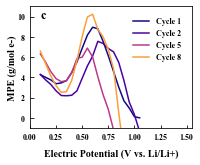

In [61]:
MPEfig = plt.figure()

ax = MPEfig.add_axes([0.2,0.21,0.75,0.75])
MPEfig.set_size_inches([3.0,2.25])

# Plot the data for select, representative cycles:
for i in cycles[[0,1,4,7]]:
        plt.plot(Potentials[1:-1],mpe[i,:-1],color = colors[i])
        
# Set the tick parameters:
ax = plt.gca()
ax.get_yaxis().set_tick_params('both', direction='in',pad=5.0)
ax.get_xaxis().set_tick_params('both', direction='in',pad=5.0)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(8)
    tick.label1.set_fontname(fontname)

# Set the tick labels for the x-axis such that they match those in figures 4a and 4b:
plt.xticks([0.00,0.25,0.50,0.75,1.00,1.25,1.50])

# Set axis limits:
plt.xlim(0.0,1.55)
plt.ylim(-1,11)

# Label the axes:
plt.xlabel('Electric Potential (V vs. Li/Li+)',fontname=fontname,fontsize=10,labelpad=7.5,fontweight='normal')
plt.ylabel('MPE (g/mol e-)',fontname=fontname,fontsize=10,labelpad=0.5)

plt.annotate('c',xy=[0.1,9.5],color='k',va='bottom',family=fontname,size=12,annotation_clip=False)

# Create the legend:
plt.legend(['Cycle 1','Cycle 2','Cycle 5','Cycle 8'],loc=1,borderaxespad = 1.0, frameon=False, prop=font)#, columnspacing = 1.0, ncol=2)

# Save the Figure:
plt.savefig('../QCM_MPE_0705.pdf',dpi=500,format='pdf')

# Inspect the Figure, here:
plt.show()

## Create and print Table 2:

The resulting text can be copied and pasted directly into the .tex file

In [62]:
MPE_cycle = -96485*1e-9*dm/Qtot
cycles = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9]])
df = pd.DataFrame(np.hstack([cycles,mtot,dm,MPE_cycle]),columns=['Cycle','Mass change // during reduciton (ng/cm^2)','Total mass at cycle end (ng/cm2)','MPE (g/mol e-)'])

print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Cycle &  Mass change // during reduciton (ng/cm\textasciicircum2) &  Total mass at cycle end (ng/cm2) &  MPE (g/mol e-) \\
\midrule
0 &    1.0 &                                 265.447823 &                        167.523266 &        4.020268 \\
1 &    2.0 &                                 432.801041 &                         96.252739 &        3.150297 \\
2 &    3.0 &                                 560.659285 &                         78.652222 &        3.238391 \\
3 &    4.0 &                                 682.629556 &                         64.386827 &        3.089969 \\
4 &    5.0 &                                 783.027871 &                         62.195203 &        3.258304 \\
5 &    6.0 &                                 898.756194 &                         76.584646 &        4.535830 \\
6 &    7.0 &                                 999.905470 &                         58.037875 &        4.008664 \\
7 &    8.0 &                           

In [36]:
cycles = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9]])
df = pd.DataFrame(np.hstack([cycles,dm_lowV,dm_highV]),columns=['Cycle','Mass change // < 1.0 V (ng/cm^2)','Mass change // > 1.0 V (ng/cm^2)'])

print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Cycle &  Mass change // < 1.0 V (ng/cm\textasciicircum2) &  Mass change // > 1.0 V (ng/cm\textasciicircum2) \\
\midrule
0 &    1.0 &                        295.846476 &                        -30.398650 \\
1 &    2.0 &                        201.595155 &                        -34.201178 \\
2 &    3.0 &                        181.696239 &                        -53.795251 \\
3 &    4.0 &                        169.452337 &                        -47.458656 \\
4 &    5.0 &                        154.559100 &                        -54.078054 \\
5 &    6.0 &                        148.583638 &                        -32.772436 \\
6 &    7.0 &                        137.153587 &                        -35.902676 \\
7 &    8.0 &                        126.539004 &                        -29.765628 \\
8 &    9.0 &                        134.245752 &                        -23.607571 \\
\bottomrule
\end{tabular}



## Total m.p.e. over the entire CV cycling process:

In [65]:
mpe_tot = -96485*1e-9*Cycle9['Mass'].values[-1]/QCMData[QCMData['Cycle'] == 9]['Q'].values[-1]
print('Total MPE during CV cycles = ',mpe_tot, ' ng/cm2')

Total MPE during CV cycles =  25.258317230395555  ng/cm2
